In [1]:
##Results of Review into PA matching studies
##Summary figures and tables
## 8/03/22
##J Morley

In [2]:
library(tidyverse)
library(cowplot)
library(MetBrewer)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
df <- read_csv('PA_matching_review.csv')

Rows: 76 Columns: 51

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (19): Paper, DOI, DOI2, Where, Scope, Outcome_varable, Sampling_ha, meth...
dbl (32): Year, field_data, common_support, mutiple_match_methods_or_covars,...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
length(df$DOI)

[1] 76

In [5]:
##chosoe pallette
pal <- as.list(met.brewer('Archambault'))

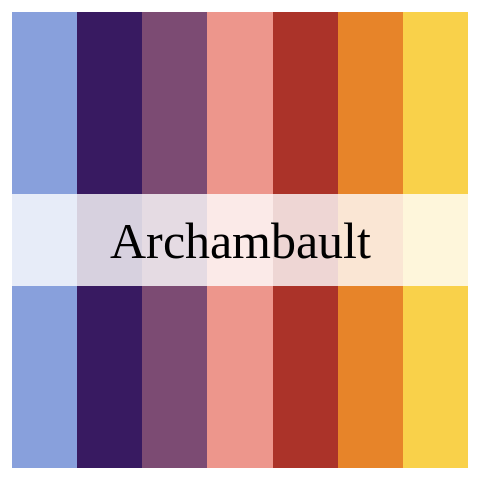

In [6]:
options(repr.plot.width=4, repr.plot.height=4)
met.brewer('Archambault')

In [7]:
df <- df %>% mutate(method2 = ifelse(str_detect(method, 'ther'), 'Other', method),
                    confoudners2 = strsplit(Confounders, ';'),
                    covar_count = map_int(confoudners2, length), 
                    caliper2 = ifelse(caliper %in% c('0.001', '0.01','0.05','0.1','0.2', 
                                                      '0.25', '0.5', '1', 'varies'), 'yes', 
                                      ifelse(caliper == 'none', 'no', caliper)),
                    ratio2 = ifelse(ratio %in% c('1-to-2', '1-to-4','1-to-5','1-to-10','varies'), '1-to-2+', ratio),
                    exact_for_groups2 = ifelse(exact_for_groups == 0, 'no', 'yes'),
                    sampling_replacement2 = ifelse(sampling_replacement == 0, 'no', 
                                                   ifelse(sampling_replacement == 1, 'yes', sampling_replacement)))

In [8]:
##create sumamry of confoudners as a matrix
cov <- df %>% select(Paper, Confounders) %>% 
                separate(Confounders, into = paste0('var',seq(1,19)), sep = ';') %>%
                pivot_longer(cols = starts_with('var'), names_to = 'var', values_to = 'conf') %>%
                drop_na() %>%
                filter(conf != '') %>%
                #select() %>%
                mutate(count = as.numeric(1), conf = gsub(' ', '_', conf))  %>%
                pivot_wider(id_cols  = Paper, names_from = conf, values_from = count, values_fill = 0, values_fn = sum)

Warning message:
“Expected 19 pieces. Missing pieces filled with `NA` in 76 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [9]:
##which are the msot commonly used confoudners
cov_sum <- cov %>%
            select_if(is.numeric) %>%
            map_dbl(sum)

In [10]:
##combine simalir confounders
cov2 <- cov %>% mutate(distance_to_nearest_or_density_of_roads = distance_to_nearest_road + density_of_roads, 
                distance_or_travel_time_to_large_population_center = distance_to_large_population_center + 
                                                                        travel_time_to_large_population_center,
                 forest_or_tree_cover_or_density = forest_cover + tree_cover + forest_density + woody_biomass_density + biomass_density,
                 vegetation_forest_or_land_cover_or_use_type = forest_type + vegetation_type + land_cover_type + land_use_type,
                 agricultural_or_land_use_suitability_potenial_or_capacity =  agricultural_suitability + land_use_capacity 
                                                                             + agricultural_potenial + land_suitability + 
                                                                                land_use_productivity,
                         .keep = 'unused')

In [12]:
##which are the msot commonly used confoudners
cov_sum <- cov2 %>%
            select_if(is.numeric) %>%
            map_dbl(sum) %>%
            as.data.frame() %>%
            rename('num_papers' = '.') %>%
            mutate(conf = rownames(.), confounder = gsub('_', ' ', conf)) %>%
            select(confounder, num_papers)

rownames(cov_sum) <- NULL

In [13]:
cov_sum2 <- cov_sum %>% 
                filter(num_papers > 6) %>% 
                arrange(desc(num_papers))

In [14]:
#write.csv(cov_sum2, 'top_covariates.csv')

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


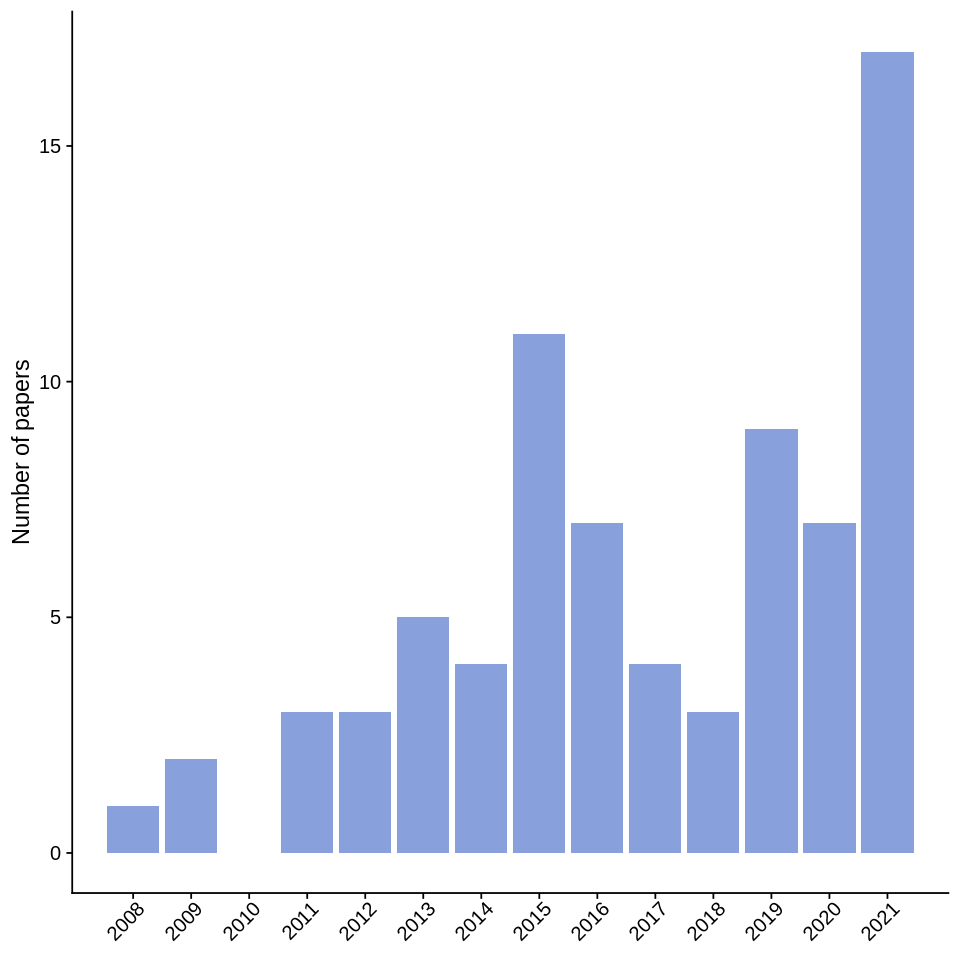

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

(a <- ggplot() +
         geom_bar(data = df, aes(x=Year), fill = pal[1]) +
         theme_cowplot() +
         labs(y = 'Number of papers', x = NULL) +
         scale_x_discrete(limits = seq(2008,2021)) +
         theme(axis.text.x = element_text(hjust = 0.9, angle=45), 
               text = element_text(size = 14), 
                  legend.title = element_blank())
 )
 

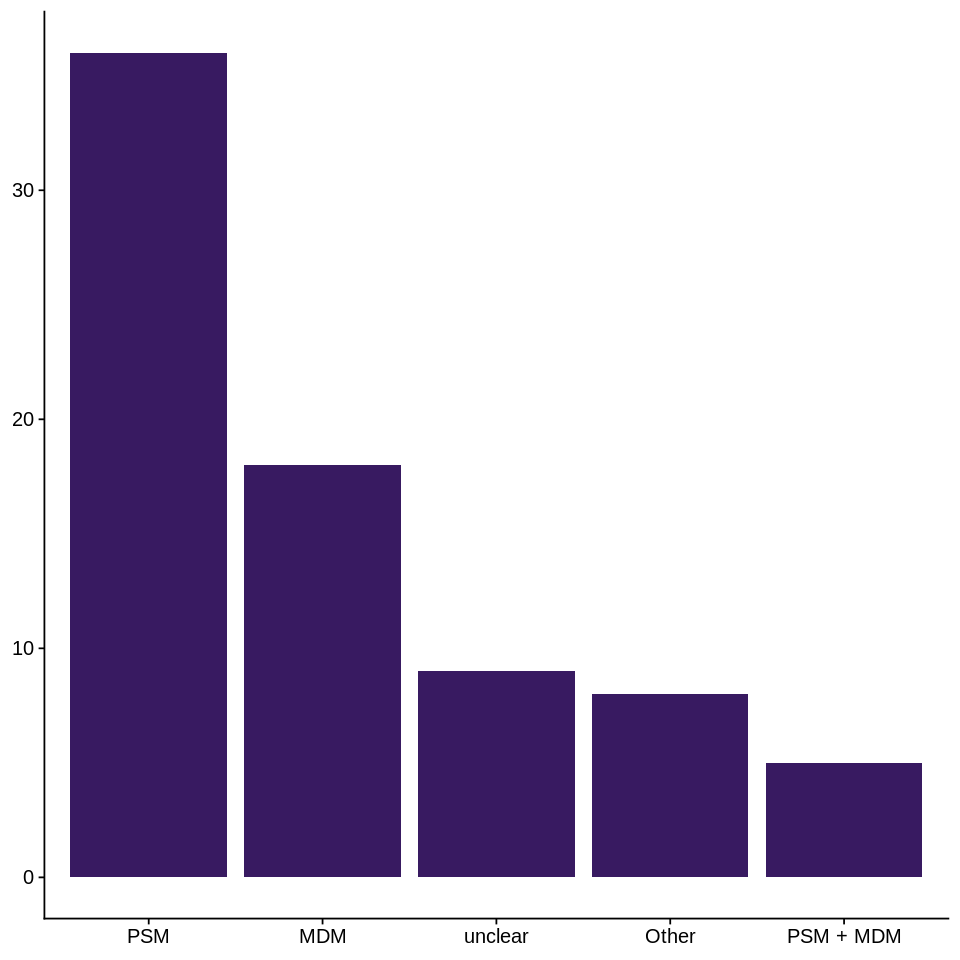

In [16]:
(b <- ggplot() +
         geom_bar(data = df, aes(x=method2), fill = pal[2]) +
         theme_cowplot() +
         labs(y = NULL, x = NULL) +
         scale_x_discrete(limits = c('PSM', 'MDM', 'unclear', 'Other', 'PSM + MDM')) +
         theme(text = element_text(size = 14), 
                  legend.title = element_blank())
 )

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


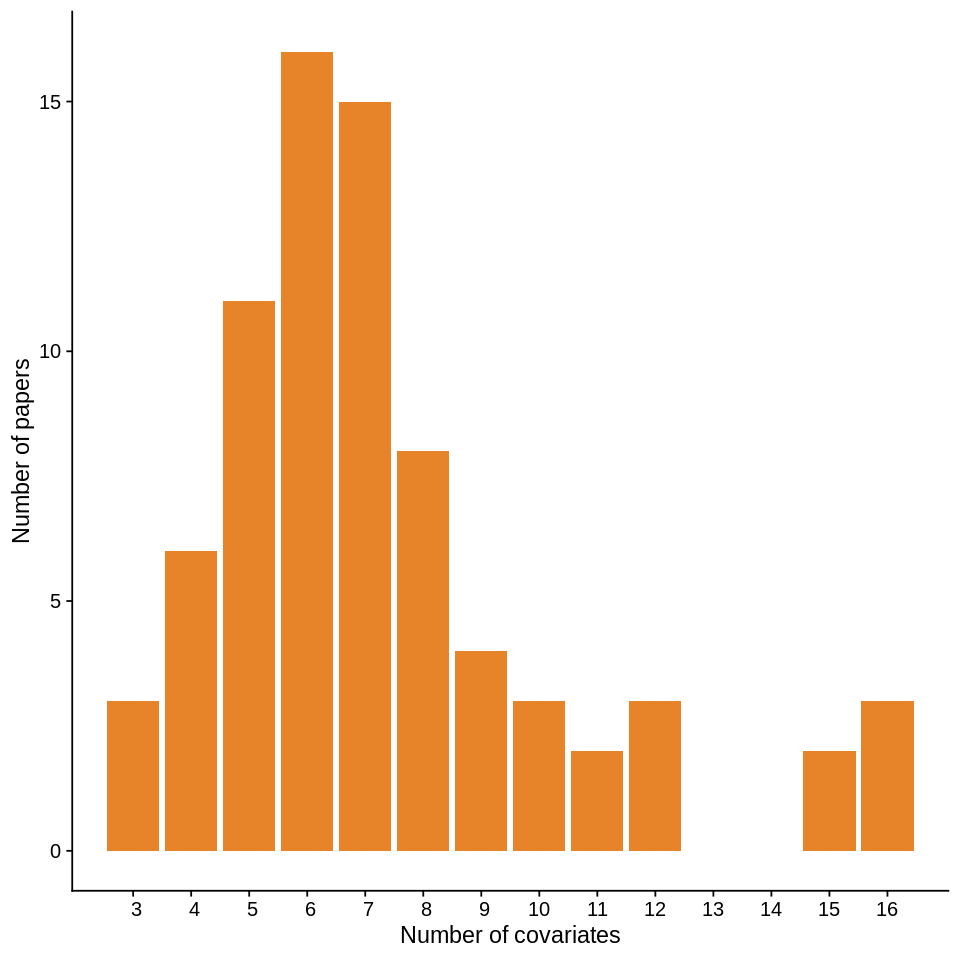

In [17]:
(c <- ggplot() +
         geom_bar(data = df, aes(x=Number_confoudners), fill = pal[6]) +
         theme_cowplot() +
         labs(y = 'Number of papers', x = 'Number of covariates') +
         scale_x_discrete(limits = seq(3,16)) +
         theme(text = element_text(size = 14), 
                  legend.title = element_blank()) 
 )

In [18]:
table(df$Number_confoudners)


 3  4  5  6  7  8  9 10 11 12 15 16 
 3  6 11 16 15  8  4  3  2  3  2  3 

In [19]:
min(df$covar_count)
median(df$covar_count)
median(df$covar_count[df$method == 'PSM'])
median(df$covar_count[df$method == 'MDM'])

[1] 3

[1] 7

[1] 7

[1] 6

In [20]:
params1 = df %>% select(Paper, caliper2) %>%
                    group_by(caliper2) %>%
                    summarize(count = length(Paper)) %>%
                    rename('value' = 'caliper2') %>%
                    mutate(parameter = 'caliper')

params2 = df %>% select(Paper, exact_for_groups2) %>%
                    group_by(exact_for_groups2) %>%
                    summarize(count = length(Paper)) %>%
                    rename('value' = 'exact_for_groups2') %>%
                    mutate(parameter = 'exact')

params3 = df %>% select(Paper, sampling_replacement2) %>%
                    group_by(sampling_replacement2) %>%
                    summarize(count = length(Paper)) %>%
                    rename('value' = 'sampling_replacement2') %>%
                    mutate(parameter = 'replacement')

params = bind_rows(params1, params2, params3) 

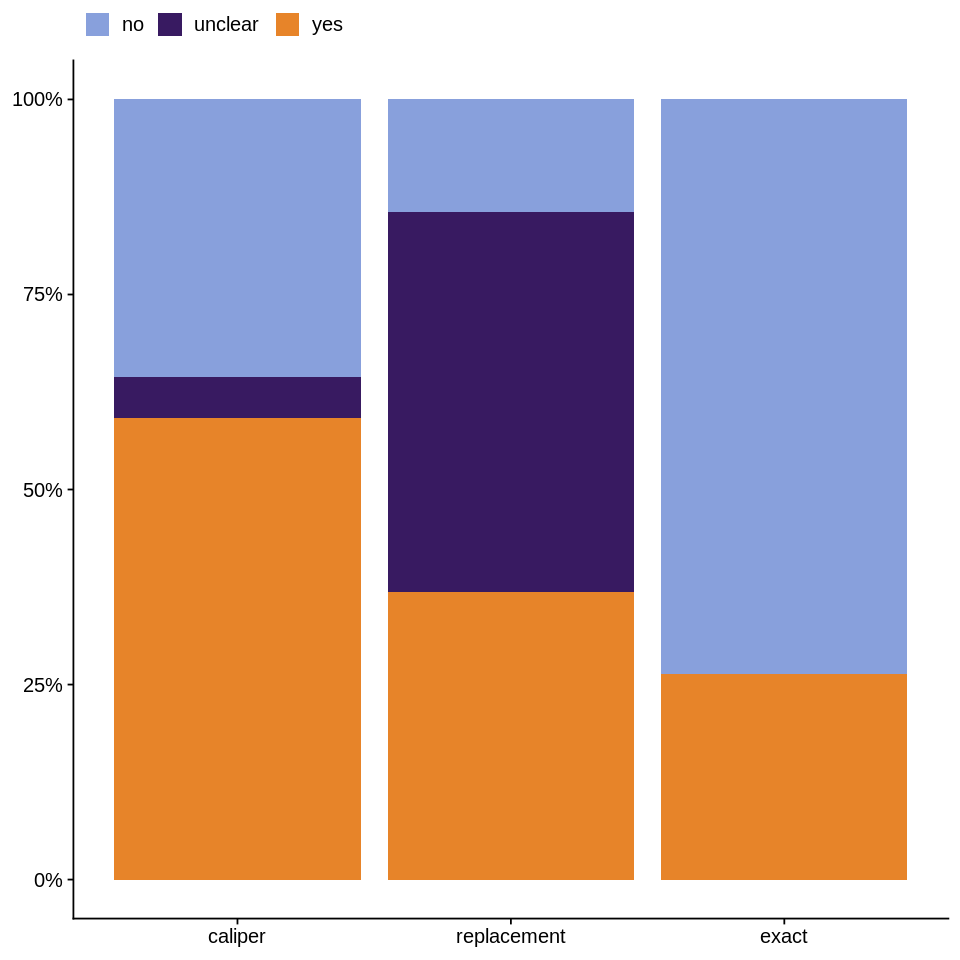

In [21]:
(d <- ggplot() +
         geom_col(data = params, aes(x = parameter, y = count, fill = value), position = 'fill') +
         theme_cowplot() +
         labs(y = NULL, x = NULL) +
         scale_fill_manual(values = c(pal[1], pal[2], pal[6]))  +
         scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
         scale_x_discrete(limits = c('caliper', 'replacement', 'exact')) +
         theme(text = element_text(size = 14), 
               legend.position = 'top',
                  legend.title = element_blank())
 )

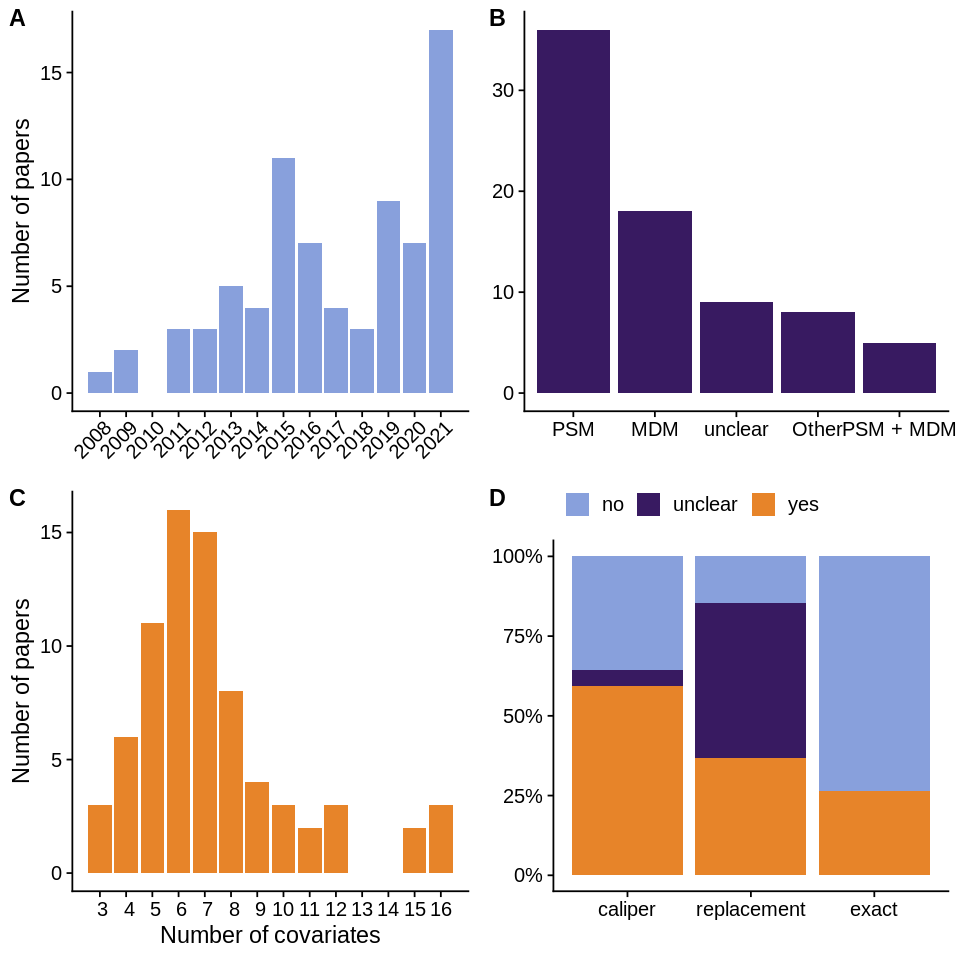

In [28]:
#(grid <- plot_grid(a, b, c, d, labels = c('A', 'B', 'C', 'D'), label_size = 14))
(grid <- plot_grid(a, b, c, d, labels = 'AUTO', align = 'h', axis="rb", label_size = 14))

In [29]:
ggsave(grid, device = 'png', filename = 'review_results_plt.png', width = 10, height = 10)

In [86]:
table(df$sampling_replacement2)
table(df$caliper2)
table(df$exact_for_groups2)
table(df$exact_for_groups)
table(df$caliper[df$method == 'MDM'])
table(df$caliper[df$method == 'PSM'])


     no unclear     yes 
     11      37      28 


     no unclear     yes 
     26       4      45 


 no yes 
 56  20 


                                              0 
                                             56 
                           adminstrative region 
                                              1 
   agricultural suitability and vegetation type 
                                              1 
                     Basline forest cover group 
                                              1 
                                          biome 
                                              1 
                                        country 
                                              4 
                          Country and ecoregion 
                                              1 
country, land cover, soil type, nutrient levels 
                                              1 
                                  country/state 
                                              1 
                                      ecoregion 
                                              1 
                   


   0.25     0.5       1    none unclear  varies 
      2       4       1       7       1       3 


  0.001    0.01    0.05     0.1     0.2    0.25     0.5    none unclear  varies 
      1       3       2       1       2       8       4      10       2       3 

In [116]:
table(df$'Spatial auto-corelation')


                                                      0 
                                                     24 
                              Clustered standard errors 
                                                      3 
                                     Hierarchical model 
                                                      1 
            Not mentioned but clustered standard errors 
                                                      1 
                    Not mentioned but sub-sampling done 
                                                     15 
                                          Spatial model 
                                                      1 
                                 Sub-sampling to reduce 
                                                     23 
         Sub-sampling to reduce (tested with varigrams) 
                                                      1 
   Sub-Sampling to reduce and clustered standard errors 
                              

In [117]:
table(df$residual_SA_tested)


 0  1 
69  7 